# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

### Marc Badger
#### June 8, 2017
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

#from scipy.interpolate import UnivariateSpline

import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


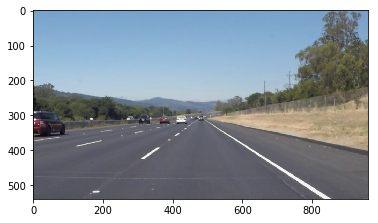

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions.  New functions that differ from those given in the template are:

grayscale()

get_line_slope()

get_line_intercept()

get_left_lines()

get_right_lines()

filter_lines_around_median()

generate_smooth_line()

draw_final_lines()


In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    
    Finds an image mask based on a HLS color range.
    
    Keeps the region of the image defined by the color range.
    Rest of the image is set to black.
    
    Returns the original image with all masked pixels black.
    
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    # convert from RGB to HLS to more easily emphasize yellow and white
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    
    # sorta works for challenge
    # select yellow mask
    #lower_y = np.array([100, 100, 0])
    #upper_y = np.array([255,255,150])
    #mask_y = cv2.inRange(img, lower_y, upper_y)
    
    # select white mask
    #lower_w = np.array([0, 200, 0])
    #upper_w = np.array([255,255,255])
    #mask_w = cv2.inRange(img, lower_w, upper_w)
    
    #lower_cement = np.array([0,0,0])
    #upper_cement = np.array([255,255,100])
    #mask_cement = cv2.inRange(img, lower_cement, upper_cement)
    
    #mask_both = cv2.bitwise_or(mask_cement, mask_w)
    
    
    # select yellow mask
    lower_y = np.array([180, 180, 50])
    upper_y = np.array([255,255,150])
    mask_y = cv2.inRange(img, lower_y, upper_y)
    
    # select white mask
    lower_w = np.array([0, 200, 0])
    upper_w = np.array([255,255,255])
    mask_w = cv2.inRange(img, lower_w, upper_w)
    
    mask_both = cv2.bitwise_or(mask_y, mask_w)
    
    im_return = cv2.bitwise_and(img, img, mask = mask_both)
    im_return = cv2.cvtColor(im_return, cv2.COLOR_HLS2RGB)
    
    return cv2.cvtColor(im_return, cv2.COLOR_RGB2GRAY)
    
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices_outer, vertices_inner):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        keep_mask_color = (0,) * channel_count
    else:
        ignore_mask_color = 255
        keep_mask_color = 0
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices_outer, ignore_mask_color)
    cv2.fillPoly(mask, vertices_inner, keep_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    if showIntermediateOutput:
        plt.figure()
        plt.suptitle('Region of interest:', fontsize=12)
        plt.imshow(mask, cmap = 'gray')
        
        plt.figure()
        plt.suptitle('Masked image', fontsize=12)
        plt.imshow(masked_image, cmap = 'gray')
    
    return masked_image

def get_line_slope(line):
    """
    Takes in a line = [x1, y1, x2, y2] in image coordinates (down and to the right from top left)
    Outputs the slope of the line in a coordinate system with x and y pointing right and upward
    respectively
    """
    if line[0] == line[2]:
        return(10000) # handle the case where we would have a line of infinte slope
    else:
        m = ((imshape[0]-line[1])-(imshape[0]-line[3]))/(line[0]-line[2])
        return(np.arctan(m))

def get_line_intercept(line):
    """
    Takes in a line = [x1, y1, x2, y2] in image coordinates (down and to the right from top left)
    Outputs the intercept of the line in a coordinate system with x and y pointing right and upward
    respectively, starting from the bottom left corner of the image.
    """
    if line[0] == line[2]:
        return(10000) # handle the case where we would have a line of infinite slope
    else:
        m = ((imshape[0]-line[1])-(imshape[0]-line[3]))/(line[0]-line[2])
        intercept = (imshape[0]-line[1]) + m*(0-line[0])
        return(intercept)

def get_left_lines(lines):
    """
    Returns a subset of the lines that have slopes between 0.3 and 0.8 (i.e. the left lines)
    """
    line_slopes = np.array([get_line_slope(x[0]) for x in lines])
    return(lines[(line_slopes > 0.3) & (line_slopes < 0.8)])

def get_right_lines(lines):
    """
    Returns a subset of the lines that have slopes between -0.3 and -0.8 (i.e. the right lines)
    """
    line_slopes = np.array([get_line_slope(x[0]) for x in lines])
    return(lines[(line_slopes < -0.3) & (line_slopes > -0.8)])

def filter_lines_around_median(target_line_group):
    """
    Takes in a set of lines and returns the subset of lines that fall within 0.05 of the median
    slope and within 50 of the median intercept.
    
    Median filtering is a basic way of filtering out bad lines.  A more advanced way would be to
    fit a surface to the distributions slopes and intercepts and take the two largest peaks that
    satisfy certain distance and prominance requirements.
    
    """
    line_slopes = [get_line_slope(x[0]) for x in target_line_group]
    line_intercepts = [get_line_intercept(x[0]) for x in target_line_group]

    m_slope, m_intercept = [np.median(line_slopes), np.median(line_intercepts)]

    filtered_lines = target_line_group[(np.absolute(line_slopes - m_slope) < 0.05) 
                                       & (np.absolute(line_intercepts - m_intercept) < 50)]
    return(filtered_lines)

def draw_lines_simple(img, lines, thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_color = [255,0,0]
    right_color = [0,255,0]
    
    left_lines = filter_lines_around_median(get_left_lines(lines))
    right_lines = filter_lines_around_median(get_right_lines(lines))

    for line in left_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), left_color, thickness)
    
    for line in right_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), right_color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, simple_lines):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    try:
        if simple_lines:
            draw_lines_simple(line_img, lines)
        else:
            draw_final_lines(line_img, lines)
    except Exception as e:
        print('No lines detected!')
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def sub_sample_line(line):
    """
    NOT CURRENTLY USED.
    
    Creates a set of points along a line specified by its endpoints. Number of points is proportional
    to the distance between the endpoints in pixels.
    
    """
    x1, y1, x2, y2 = line
    y1 = imshape[0] - y1
    y2 = imshape[0] - y2
    slope = get_line_slope(line)
    intercept = get_line_intercept(line)
    xs = np.linspace(x1, x2, round(np.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))))
    ys = intercept + slope * xs
    return np.column_stack((xs, ys))

def generate_smooth_line(target_line_group):
    """
    Takes in a set of lines, either from the left or right lane line, filters out
    the lines that are too far away from the median slope and intercept, and then
    fits a polynomial to the line endpoints. You can also implement spline fitting
    here as well.

    Returns a set of points along the line/quadratic/spline that represent the best guess
    for the lane line.  Points are trimmed vertically to end at the last detected line, so
    that we don't give a false impression of the data we used to generate the line.
    
    These points will be plotted as line segments in the draw_final_lines() function.
    """
    #global no_lines_detected_yet
    #global old_points_in_frame
    
    filtered_lines = filter_lines_around_median(target_line_group)
    
    if len(filtered_lines) < 1:
        #if no_lines_detected_yet:
        #    return []
        #else:
        #    return old_points_in_frame
        return []
    
    # Didn't work to try to fit a function to points along the lines
    #line_sample_points = np.array([[0, 0]])
    #for line in filtered_lines:
    #    points_on_line = sub_sample_line(line[0])
    #    line_sample_points = np.vstack((line_sample_points, points_on_line))

    #line_sample_points = np.delete(line_sample_points, 0, 0)
    #some_xs = line_sample_points[:,0]
    #some_ys = line_sample_points[:,1]

    # It works fine to just fit to the endpoints of each line:
    # it's better to fit x vs y because curving road lines might not be "functions"
    # because they have more than one height for the same image width position value
    # rarely will a curve be so extreme that the same line has two different width values
    some_xs = np.array([x[0,(0,2)] for x in filtered_lines]).flatten()
    some_ys = np.array([x[0,(1,3)] for x in filtered_lines]).flatten()
    
    z = np.polyfit(some_ys, some_xs, 1) # change from a 2 to 1 if you want straight lines.
    p = np.poly1d(z)
    
    #p = UnivariateSpline(some_xs, some_ys, k = 3, s = 0)
    
    #xp = np.linspace(np.min(some_xs),np.max(some_xs),100)
    #xp = np.linspace(0, imshape[1] ,400)
    yp = np.linspace(310, imshape[0] ,400)

    xp = p(yp)
    
    points = np.column_stack((xp, yp))
    
    #points_in_frame = points[(points[:,1] >0) & (points[:,1] > np.max(some_ys))]
    points_in_frame = points[(points[:,1] > np.min(some_ys))]

    
    # very simple smoothing (if you can't find lines, give the previous lines)
    # actually this would be dangerous to do in a real pipeline!
    #old_points_in_frame = points_in_frame
    #no_lines_detected_yet = False
    
    return points_in_frame

def draw_final_lines(img, lines, thickness=20):
    """
    Takes in an image and a set of points from the generate_smooth_line() function.
    Draws a single line connecting all points. No line is drawn if no points were found.
    """
    left_color = [255,0,0]
    right_color = [0,255,0]
    
    left_lines = get_left_lines(lines)
    right_lines = get_right_lines(lines)
    
    left_smoothed_points = generate_smooth_line(left_lines)
    if len(left_smoothed_points) > 2:
        for i in range(0,len(left_smoothed_points)-2):
            x1, y1 = left_smoothed_points[i].astype(int)
            x2, y2 = left_smoothed_points[i+1].astype(int)
            decreased_thickness = int(8+40*(y1-310)/(imshape[1]-310))
            cv2.line(img, (x1, y1), (x2, y2), left_color, decreased_thickness)
            

    right_smoothed_points = generate_smooth_line(right_lines)
    if len(right_smoothed_points) > 2:
        for i in range(0,len(right_smoothed_points)-2):
            x1, y1 = right_smoothed_points[i].astype(int)
            x2, y2 = right_smoothed_points[i+1].astype(int)
            decreased_thickness = int(8+40*(y1-310)/(imshape[1]-310))
            cv2.line(img, (x1, y1), (x2, y2), right_color, decreased_thickness)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

showIntermediateOutput = False

In [5]:
def process_image(image):
    """
    Takes in a single color image and calls all of the helper functions listed above.
    A good place to adjust all the hyperparameters.
    Outputs the image with a best-fit line for right and left lane lines.
    """
    
    global imshape # a lot of the helper functions need imshape, and having a global variable was
                    # easier than having imshape as an input for every function.
    
    imshape = image.shape
    
    # Select the lines based on their color, color everything else black, and convert to grayscale
    road_gray = grayscale(image)

    if showIntermediateOutput:
        plt.figure()
        plt.suptitle('After the grayscale function, which converts to HLS, selects a '
                     'predetermined color range, and converts the output to grayscale.', fontsize=12)
        plt.imshow(road_gray, cmap = 'gray')

    # Blur the image a bit to prevent the Canny edge detector from finding small-scale lines
    kernel_size = 7
    blurry_gray = gaussian_blur(road_gray, kernel_size)

    if showIntermediateOutput:
        plt.figure()
        plt.suptitle('Then we blur the image to prevent image noise from causing spurrious edges:', fontsize=12)
        plt.imshow(blurry_gray, cmap = 'gray')

    # Do the Canny edge detection
    low_canny_threshold = 6 # 6
    high_canny_threshold = 81 # 81
    edges = canny(blurry_gray, low_canny_threshold, high_canny_threshold)

    if showIntermediateOutput:
        plt.figure()
        plt.suptitle('These are the edges:', fontsize=12)
        plt.imshow(edges, cmap = 'gray')
    
    
    # Define a region of interest where we'll look for lines
    vertices_outer = np.array([[(50, imshape[0]), (imshape[1]/2-70,350), 
                                (imshape[1]/2+70,350), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    vertices_inner = np.array([[(170, imshape[0]), (imshape[1]/2-0, 450), 
                                (imshape[1]/2+0, 450), (imshape[1]-170,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices_outer, vertices_inner)
    
    # Do a Hough transform on the masked_edges image
    rho = 1 # distance resolution in pixels of the Hough grid # 1
    theta = 0.03 # angular resoludion in radians of the Hough grid # 0.03
    threshold = 6 # minimum number of votes (intersections in Hough grid cell) # 6
    min_line_len = 30 # minimum number of pixels making up a line # 30
    max_line_gap = 60 # maximum gap in pixels between connectable line segments # 60

    hough_line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len=min_line_len, 
                                   max_line_gap=max_line_gap, simple_lines = False)
    result = weighted_img(hough_line_image, image)
    
    if showIntermediateOutput:
        simple_line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len=min_line_len, 
                                        max_line_gap=max_line_gap, simple_lines = True)
        simple_result = weighted_img(simple_line_image, image)
        
        plt.figure()
        plt.suptitle('Here was the original image:', fontsize=12)
        plt.imshow(image)
        
        plt.figure()
        plt.suptitle('And here are the simple lines:', fontsize=12)
        plt.imshow(simple_result)
        
        plt.figure()
        plt.suptitle('After fitting a line, parabola, or smoothing function to the endpoints '
                     'of the lines, we get our final result:', fontsize=12)
        plt.imshow(result)
    
    return result

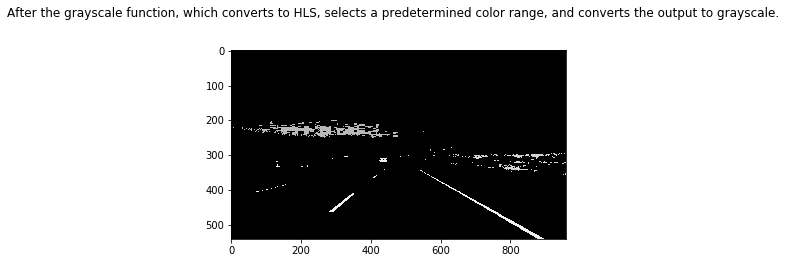

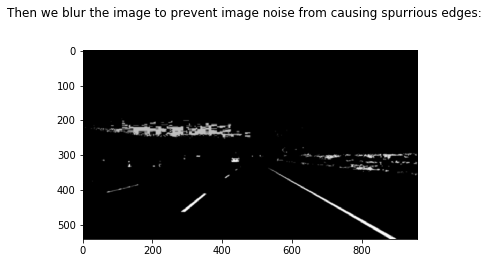

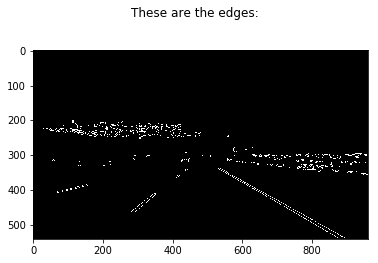

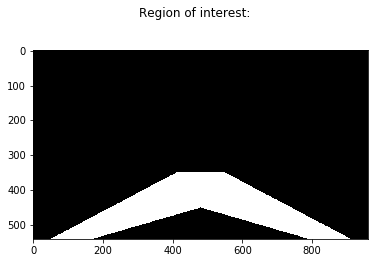

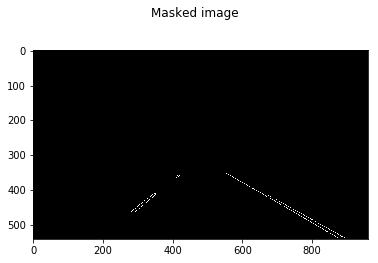

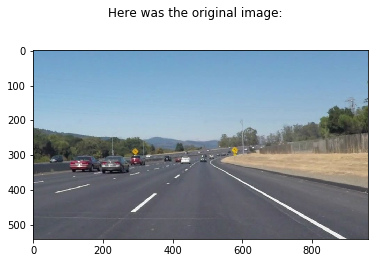

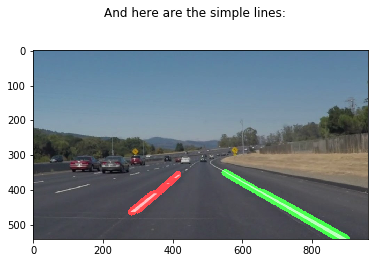

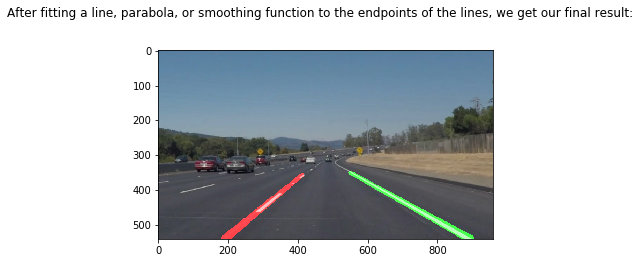

In [6]:
imageFileNames = os.listdir("test_images/")

image = mpimg.imread("test_images/" + imageFileNames[51])
# Next we'll create a masked edges image using the helper function
imshape = image.shape # rows x columns x channels

showIntermediateOutput = True

temp_image = process_image(image)
plt.imshow(temp_image)

### Let's try the one with the solid white lane on the right first ...

In [7]:
showIntermediateOutput = False
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:04<00:00, 44.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 5.32 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  4%|█████▏                                                                                                                | 30/682 [00:00<00:15, 41.74it/s]WARNING:py.warnings:C:\Users\marcbadger.MBCOMP\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

  ret = ret.dtype.type(ret / rcount)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:15<00:00, 44.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 15.7 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


Improvements iterative refinement of lane lines for each frame.  Once have the general line, search up from the bottom following bread crumbs and a prior for the shape of road curves projected onto the camera image.

Instead of fitting a line or parabola to the points, also impose a slope range for what angles the lane line is allowed to intersect the bottom of the image.

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_2.mp4
[MoviePy] Writing video test_videos_output/challenge_2.mp4


 59%|████████████████████████████████████████████████████████████████████▌                                                | 147/251 [00:05<00:04, 24.07it/s]WARNING:py.warnings:C:\Users\marcbadger.MBCOMP\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

  ret = ret.dtype.type(ret / rcount)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 25.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_2.mp4 

Wall time: 10.8 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## The rest of this notebook contains code I used to prototype the helper functions above.

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Read in an Image

In [ ]:
imageFileNames = os.listdir("test_images/")

image = mpimg.imread("test_images/" + imageFileNames[56])
# Next we'll create a masked edges image using the helper function
imshape = image.shape # rows x columns x channels

showIntermediateOutput = True

In [ ]:
gcol=90
bcol=90
rcol=110
grange=20
brange=25
rrange=25

lower = np.array([gcol-grange,bcol-brange,rcol-rrange], dtype = "uint8")
upper = np.array([gcol+grange,bcol+brange,rcol+rrange], dtype = "uint8")
raw_mask = cv2.inRange(image, lower, upper)

# erode to get rid of small things (we just want the main road blob)
# dilate to get the part of the road we eroded back
erosion_kernel = np.ones((5,5), np.uint8)
dilation_kernel = np.ones((9,9),np.uint8)
im_eroded = cv2.erode(raw_mask, erosion_kernel, iterations = 4)
im_dilated = cv2.dilate(im_eroded, dilation_kernel, iterations = 7)
im_dilated = cv2.erode(im_dilated, erosion_kernel, iterations = 2)

im_gray_return = cv2.bitwise_and(image, image, mask=im_dilated)

if showIntermediateOutput:
    plt.figure()
    plt.imshow(image)
    plt.figure()
    plt.imshow(im_dilated)
    plt.figure()
    plt.imshow(im_gray_return)

In [ ]:
def get_road_mask(image, gcol=90, bcol=90, rcol=110, grange=20, brange=25, rrange=25):
    """
    NOT CURRENTLY USED
    
    Finds an image mask based on a color range.
    
    Keeps the region of the image defined by the color range.
    Rest of the image is set to black.
    
    Returns the original image with all masked pixels black.
    """
    
    lower = np.array([gcol-grange,bcol-brange,rcol-rrange], dtype = "uint8")
    upper = np.array([gcol+grange,bcol+brange,rcol+rrange], dtype = "uint8")
    raw_mask = cv2.inRange(image, lower, upper)

    # erode to get rid of small things (we just want the main road blob)
    # dilate to get the part of the road we eroded back
    erosion_kernel = np.ones((5,5), np.uint8)
    dilation_kernel = np.ones((9,9),np.uint8)
    im_eroded = cv2.erode(raw_mask, erosion_kernel, iterations = 4)
    im_dilated = cv2.dilate(im_eroded, dilation_kernel, iterations = 7)
    im_dilated = cv2.erode(im_dilated, erosion_kernel, iterations = 2)
    
    # mask the image
    im_return = cv2.bitwise_and(image, image, mask=im_dilated)
    
    if showIntermediateOutput:
        plt.figure()
        plt.suptitle('Input image:', fontsize=12)
        plt.imshow(image)
        
        plt.figure()
        plt.suptitle('Road mask', fontsize=12)
        plt.imshow(im_dilated, cmap='gray')
        
        plt.figure()
        plt.suptitle('Only the road:', fontsize=12)
        plt.imshow(im_return)
    
    # return a 3 channel image for ease of use
    return im_return

In [ ]:
road_only = get_road_mask(image)

In [ ]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
    
    # convert from RGB to HLS to more easily emphasize yellow and white
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
    # select yellow mask
    #lower_y = np.array([180, 180, 50])
    lower_y = np.array([100, 100, 0])
    upper_y = np.array([255,255,150])
    #upper_y = np.array([255,255,100])
    mask_y = cv2.inRange(img, lower_y, upper_y)
    
    # select white mask
    lower_w = np.array([0, 200, 0])
    upper_w = np.array([255,255,255])
    mask_w = cv2.inRange(img, lower_w, upper_w)
    
    lower_cement = np.array([0,0,0])
    upper_cement = np.array([255,255,100])
    mask_cement = cv2.inRange(img, lower_cement, upper_cement)
    #mask_cement = cv2.bitwise_not(mask_cement, mask_cement)
    
    #mask_y_not_cement = cv2.bitwise_and()

    #mask_both = cv2.bitwise_or(mask_y, mask_w)
    mask_both = cv2.bitwise_or(mask_cement, mask_w)
    
    im_return = cv2.bitwise_and(image, image, mask = mask_both)
    
    return im_return
    
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [ ]:
hsl = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# select yellow mask
lower_y = np.array([180, 180, 50])
upper_y = np.array([255,255,150])
mask_y = cv2.inRange(image, lower_y, upper_y)
print(type(mask_y))

# select white mask
lower_w = np.array([0, 200, 0])
upper_w = np.array([255,255,255])
mask_w = cv2.inRange(image, lower_w, upper_w)
print(type(mask_w))

mask_both = cv2.bitwise_or(mask_y, mask_w)
plt.figure()
plt.imshow(mask_both, cmap = 'gray')
print(type(mask_both))

im_return = cv2.bitwise_and(image, image, mask = mask_both)
print(type(im_return))

plt.figure()
plt.imshow(im_return)

In [ ]:
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(grayscale(image))

In [ ]:
#road_gray = grayscale(road_only)
road_gray = grayscale(image)


if showIntermediateOutput:
    plt.figure()
    plt.imshow(road_gray, cmap = 'gray')

# Blur the image a bit to prevent the Canny edge detector from finding small-scale lines
kernel_size = 21
blurry_gray = gaussian_blur(road_gray, kernel_size)

if showIntermediateOutput:
    plt.figure()
    plt.imshow(blurry_gray, cmap = 'gray')

# Do the Canny edge detection
low_canny_threshold = 6
high_canny_threshold = 81
edges = canny(blurry_gray, low_canny_threshold, high_canny_threshold)

if showIntermediateOutput:
    plt.figure()
    plt.imshow(edges, cmap = 'gray')

In [ ]:
def region_of_interest(img, vertices_outer, vertices_inner):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        keep_mask_color = (0,) * channel_count
    else:
        ignore_mask_color = 255
        keep_mask_color = 0
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices_outer, ignore_mask_color)
    cv2.fillPoly(mask, vertices_inner, keep_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    if showIntermediateOutput:
        plt.figure()
        plt.imshow(mask, cmap = 'gray')
        plt.figure()
        plt.imshow(masked_image, cmap = 'gray')
    
    return masked_image

In [ ]:
# Next we'll create a masked edges image using the helper function
imshape = image.shape # rows x columns x channels
vertices_outer = np.array([[(50, imshape[0]), (imshape[1]/2-50,350), (imshape[1]/2+50,350), (imshape[1]-50,imshape[0])]], dtype=np.int32)
vertices_inner = np.array([[(170, imshape[0]), (imshape[1]/2-0, 450), (imshape[1]/2+0, 450), (imshape[1]-170,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices_outer, vertices_inner)

In [ ]:
def get_line_slope(line):
    """
    Takes in a line = [x1, y1, x2, y2] in image coordinates (down and to the right from top left)
    Outputs the slope of the line in a coordinate system with x and y pointing right and upward
    respectively
    """
    if line[0] == line[2]:
        return(10000)
    else:
        m = ((imshape[0]-line[1])-(imshape[0]-line[3]))/(line[0]-line[2])
        return(np.arctan(m))

def get_line_intercept(line):
    """
    Takes in a line = [x1, y1, x2, y2] in image coordinates (down and to the right from top left)
    Outputs the intercept of the line in a coordinate system with x and y pointing right and upward
    respectively, starting from the bottom left corner of the image.
    """
    if line[0] == line[2]:
        return(10000)
    else:
        m = ((imshape[0]-line[1])-(imshape[0]-line[3]))/(line[0]-line[2])
        intercept = (imshape[0]-line[1]) + m*(0-line[0])
        return(intercept)

def get_left_lines(lines):
    line_slopes = np.array([get_line_slope(x[0]) for x in lines])
    return(lines[(line_slopes > 0.3) & (line_slopes < 0.8)])

def get_right_lines(lines):
    line_slopes = np.array([get_line_slope(x[0]) for x in lines])
    return(lines[(line_slopes < -0.3) & (line_slopes > -0.8)])

def filter_lines_around_median(target_line_group):
    line_slopes = [get_line_slope(x[0]) for x in target_line_group]
    line_intercepts = [get_line_intercept(x[0]) for x in target_line_group]

    m_slope, m_intercept = [np.median(line_slopes), np.median(line_intercepts)]

    filtered_lines = target_line_group[(np.absolute(line_slopes - m_slope) < 0.05) & (np.absolute(line_intercepts - m_intercept) < 50)]
    return(filtered_lines)

def draw_lines_simple(img, lines, thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_color = [255,0,0]
    right_color = [0,255,0]
    
    left_lines = filter_lines_around_median(get_left_lines(lines))
    right_lines = filter_lines_around_median(get_right_lines(lines))

    for line in left_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), left_color, thickness)
    
    for line in right_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), right_color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, simple_lines):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if simple_lines:
        draw_lines_simple(line_img, lines)
    else:
        draw_final_lines(line_img, lines)
        
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [ ]:
# Do a Hough transform
rho = 1 # distance resolution in pixels of the Hough grid
theta = 0.03 # angular resoludion in radians of the Hough grid
threshold = 6 # minimum number of votes (intersections in Hough grid cell)
min_line_len = 30 #6 # minimum number of pixels making up a line
max_line_gap = 60 #1 # maximum gap in pixels between connectable line segments

img = masked_edges

hough_line_image = hough_lines(img, rho, theta, threshold, min_line_len=min_line_len, max_line_gap=max_line_gap, simple_lines = True)
final_image = weighted_img(hough_line_image, image)

if showIntermediateOutput:
    plt.figure()
    plt.imshow(image)
    plt.figure()
    plt.imshow(final_image)

In [ ]:
lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
left_lines = get_left_lines(lines)
right_lines = get_right_lines(lines)

In [ ]:
target_line_group = left_lines
line_slopes = [get_line_slope(x[0]) for x in target_line_group]
line_intercepts = [get_line_intercept(x[0]) for x in target_line_group]

m_slope, m_intercept = [np.median(line_slopes), np.median(line_intercepts)]

print(line_slopes)
print(line_intercepts)
print(m_slope, m_intercept)

filtered_lines = target_line_group[(np.absolute(line_slopes - m_slope) < 0.05) & (np.absolute(line_intercepts - m_intercept) < 50)]

In [ ]:
def sub_sample_line(line):
    x1, y1, x2, y2 = line
    slope = get_line_slope(line)
    intercept = get_line_intercept(line)
    xs = np.linspace(x1, x2, round(np.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))))
    ys = intercept + slope * xs
    return np.column_stack((xs, ys))

In [ ]:
for line in filtered_lines:
    points_on_line = sub_sample_line(line[0])
    print(len(points_on_line))

In [ ]:
line_sample_points = np.array([[0, 0]])
for line in filtered_lines:
    points_on_line = sub_sample_line(line[0])
    line_sample_points = np.vstack((line_sample_points, points_on_line))

line_sample_points = np.delete(line_sample_points, 0, 0)

# it's better to fit x vs y because curving road lines might not be "functions"
# because they have more than one height for the same image width position value
# rarely will a curve be so extreme that the same line has two different width values
#some_xs = np.array([x[0,(0,2)] for x in filtered_lines]).flatten()
#some_ys = np.array([x[0,(1,3)] for x in filtered_lines]).flatten()

some_xs = line_sample_points[:,0]
some_ys = line_sample_points[:,1]

In [ ]:
some_xs = np.array([x[0,(0,2)] for x in filtered_lines]).flatten()
some_ys = np.array([x[0,(1,3)] for x in filtered_lines]).flatten()
z = np.polyfit(some_xs, some_ys, 2)
p = np.poly1d(z)

In [ ]:
xp = np.linspace(np.min(some_xs),np.max(some_xs),100)
plt.plot(some_xs,some_ys,'.',xp,p(xp),'-')
plt.show()

In [ ]:
def generate_smooth_line(target_line_group):
    
    #global no_lines_detected_yet
    #global old_points_in_frame
    
    filtered_lines = filter_lines_around_median(target_line_group)
    
    if len(filtered_lines) < 1:
        #if no_lines_detected_yet:
        #    return []
        #else:
        #    return old_points_in_frame
        return []
    
    # it's better to fit x vs y because curving road lines might not be "functions"
    # because they have more than one height for the same image width position value
    # rarely will a curve be so extreme that the same line has two different width values
    some_xs = np.array([x[0,(0,2)] for x in filtered_lines]).flatten()
    some_ys = np.array([x[0,(1,3)] for x in filtered_lines]).flatten()
    
    z = np.polyfit(some_ys, some_xs, 2)
    p = np.poly1d(z)
    
    #p = UnivariateSpline(some_xs, some_ys, k = 3, s = 0)
    
    #xp = np.linspace(np.min(some_xs),np.max(some_xs),100)
    #xp = np.linspace(0, imshape[1] ,400)
    yp = np.linspace(310, imshape[0] ,400)

    xp = p(yp)
    
    points = np.column_stack((xp, yp))
    
    #points_in_frame = points[(points[:,1] >0) & (points[:,1] > np.max(some_ys))]
    points_in_frame = points[(points[:,1] > np.min(some_ys))]

    
    # very simple smoothing (if you can't find lines, give the previous lines)
    # actually this would be dangerous to do in a real pipeline!
    #old_points_in_frame = points_in_frame
    #no_lines_detected_yet = False
    
    return points_in_frame

In [ ]:
filtered_lines = filter_lines_around_median(target_line_group)
some_xs = np.array([x[0,(0,2)] for x in filtered_lines]).flatten()
some_ys = np.array([x[0,(1,3)] for x in filtered_lines]).flatten()
z = np.polyfit(some_xs, some_ys, 2)
p = np.poly1d(z)

#xp = np.linspace(np.min(some_xs),np.max(some_xs),100)
xp = np.linspace(0, imshape[1] ,400)

yp = p(xp)

points = np.column_stack((xp, yp))

points_in_frame = points[(points[:,1] > 0) & (points[:,1] > 310)]

#points_in_frame

In [ ]:
left_line_points = generate_smooth_line(left_lines)
right_line_points = generate_smooth_line(right_lines)

Left lines have positive slopes (0.63 to 0.67) and negative intercepts (-128 to -153)
Right lines have negative slopes (-0.52 to -0.56) and positive intercepts (508 to 554)

In [ ]:
def filter_lines_around_median(target_line_group):
    line_slopes = [get_line_slope(x[0]) for x in target_line_group]
    line_intercepts = [get_line_intercept(x[0]) for x in target_line_group]

    m_slope, m_intercept = [np.median(line_slopes), np.median(line_intercepts)]

    filtered_lines = target_line_group[(np.absolute(line_slopes - m_slope) < 0.05) & (np.absolute(line_intercepts - m_intercept) < 50)]
    return(filtered_lines)

In [ ]:
slope, intercept = get_median_slope_and_intercept(right_lines)

In [ ]:
x1_image = (0 - left_slope_and_intercept[1])/left_slope_and_intercept[0]
y1_image = imshape[0]-0
x2_image = (210 - left_slope_and_intercept[1])/left_slope_and_intercept[0]
y2_image = imshape[0]-210
[x1_image, y1_image, x2_image, y2_image]

In [ ]:
left_final_line = make_final_line(left_lines)
right_final_line = make_final_line(right_lines)

In [ ]:
right_final_line

In [ ]:
def draw_final_lines(img, lines, thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_color = [255,0,0]
    right_color = [0,255,0]
    
    left_lines = get_left_lines(lines)
    right_lines = get_right_lines(lines)
    
    left_smoothed_points = generate_smooth_line(left_lines)
    right_smoothed_points = generate_smooth_line(right_lines)
    
    for i in range(0,len(left_smoothed_points)-2):
        x1, y1 = left_smoothed_points[i].astype(int)
        x2, y2 = left_smoothed_points[i+1].astype(int)
        decreased_thickness = int(8+40*(y1-310)/(imshape[1]-310))
        cv2.line(img, (x1, y1), (x2, y2), left_color, decreased_thickness)
    
    for i in range(0,len(right_smoothed_points)-2):
        x1, y1 = right_smoothed_points[i].astype(int)
        x2, y2 = right_smoothed_points[i+1].astype(int)
        decreased_thickness = int(8+40*(y1-310)/(imshape[1]-310))
        cv2.line(img, (x1, y1), (x2, y2), right_color, decreased_thickness)

In [ ]:
int(20-15*(y1-310)/(imshape[1]-310))

In [ ]:
left_smoothed_points = generate_smooth_line(left_lines)
right_smoothed_points = generate_smooth_line(right_lines)
x1, y1 = left_smoothed_points[1]
left_smoothed_points[99]

In [ ]:
# Do a Hough transform
rho = 1 # distance resolution in pixels of the Hough grid
theta = 0.03 # angular resoludion in radians of the Hough grid
threshold = 6 # minimum number of votes (intersections in Hough grid cell)
min_line_len = 30 #6 # minimum number of pixels making up a line
max_line_gap = 60 #1 # maximum gap in pixels between connectable line segments

img = masked_edges

hough_line_image = hough_lines(img, rho, theta, threshold, min_line_len=min_line_len, max_line_gap=max_line_gap, simple_lines = False)
final_image = weighted_img(hough_line_image, image)

if showIntermediateOutput:
    plt.figure()
    plt.imshow(image)
    plt.figure()
    plt.imshow(final_image)

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
image = clip1.get_frame(4.6)
temp_image = process_image(image)
plt.imshow(temp_image)